<h1> <a href=http://www.datascience-paris-saclay.fr/>Paris Saclay Center for Data Science</a> </h1>

<h2> RAMP on qualitative and quantitative non-invasive monitoring of anti-cancer drugs </h2>

<i>Camille Marini (LTCI/CNRS), Alex Gramfort (LTCI/Télécom ParisTech), Sana Tfaili (Lip(Sys)²/UPSud), Laetitia Le (Lip(Sys)²/UPSud), Mehdi Cherti (LAL/CNRS), Balázs Kégl (LAL/CNRS)</i>

<h2> Introduction </h2>

<p>Chemotherapy is one of the most used treatment against cancer. It uses chemical substances (<a href=https://en.wikipedia.org/wiki/List_of_chemotherapeutic_agents>chemotherapeutic agents</a>) which kill cells that divide too quickly. These chemical substances are often diluted in a particular solution and packaged in bags, diffusers, or syringes, before being administered. <a href=https://books.google.fr/books?id=EB00rD8AqaYC&pg=PA188&lpg=PA188&dq=wrong+chemotherapeutic&source=bl&ots=m7EfyG6A3J&sig=ZVa0hLqDPFe2iExV6FOREJztN8c&hl=en&sa=X&ved=0ahUKEwj_5ZinkarMAhUFnBoKHaJiAgAQ6AEIKDAC#v=onepage&q=wrong%20chemotherapeutic&f=false>Wrong medication</a>  (wrong chemotherapeutic agent or wrong concentration) can have major impacts for patients. To prevent wrong medication, some recent French regulations impose the verification of anti-cancer drugs before their administration. The goal is to check that they contain the good chemotherapeutic agent with the good dosage. 

<p><a href=https://en.wikipedia.org/wiki/Raman_spectroscopy>Raman spectroscopy</a> could be used to make this check, since, theoretically, i) each molecule has a specific spectral fingerprint by which the molecule can be identified; and ii) the Raman intensity increases with the concentration of the molecule. The main advantage of spectroscopy above other methods (for example, liquid chromatography) is that it is non-destructive and non-invasive (measures are made without opening the drug containers). However, this method is rarely used in hospital environment because of the complexity of the spectral signals to analyze. Automating the analysis of these spectral signals could significantly help. Eventually, a complete analytical system (from measuring Raman spectra to identifying the chemotherapeutic agent and its concentration) could be designed, which would be easy to use and would prevent wrong medication. 

<p>In this context, the goal of this project is to develop prediction models able to <b>identify and quantify chemotherapeutic agents from their Raman spectra</b>.  

<p>The Lip(Sys)² laboratory measured Raman spectra of 4 types of chemotherapeutic agents (called <i>molecule</i>) in 3 different packages (called <i>vial</i>), diluted in 9 different solutions (called <i>solute gammes</i>), and having different concentrations. A total of <b>360 spectra were measured for each agent</b>, except for one (348 spectra).<br>  

Part of these data are saved in the file <code>train.csv</code> as follows (<code>n_samples</code> being the number of samples): 
<ul>
    <li><b>molecule</b>: Type of chemotherapeutic agent. Six possible values: A for infliximab, B for bévacizumab, Q for ramucirumab, R for rituximab. Dimension: (<code>n_samples</code>,)</li>
    <li><b>vial</b>: Vial type. Three possible values: 1, 2, 3. Dimension: (<code>1</code>, <code>n_samples</code>)</li>
    <li><b>solute</b>: Solute group. Fourteen possible values: 1, 2, ..., 14. Dimension: (<code>1</code>, <code>n_samples</code>)</li>
    <li><b>concentration</b>: Concentration of the molecule. Dimension: (<code>n_samples</code>, <code>1</code>)</li>
    <li><b>spectra</b>: Intensity of Raman spectrum. Dimension: (<code>n_samples</code>, <code>1866</code>)</li>
</ul>

<p>To sum up, there are too objectives:

<ul>
    <li><b>classification</b>: predict which molecule it corresponds to given the spectrum.</li>
    <li><b>regression</b>: predict the concentration of a molecule. The prediction should not depend on the vial or the solute group. The error metric is the mean absolute relative error (mare): $$\frac{1}{n_{samples}}\sum_{i=1}^{n_{samples}}\left|\frac{y_i-\hat{y}_i}{y_i}\right|$$ with $y$ and $\hat{y}$ being the true and predicted concentration.</li>
</ul>

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

In [2]:
data = pd.read_csv('train.csv')

y_df = data[['molecule', 'concentration']]
X_df = data.drop(['molecule', 'concentration'], axis=1)
spectra = X_df['spectra'].values                                        
spectra = np.array([np.array(dd[1:-1].split(',')).astype(float) for dd in spectra])    
X_df['spectra'] = spectra.tolist()

In [3]:
type(data['spectra'].values[0])

str

In [4]:
print(X_df.head())
print(y_df.head())

   solute                                            spectra  vial
0      11  [0.0152963, 0.0152944, 0.0153142, 0.0154096, 0...     1
1       1  [0.0143634, 0.0143292, 0.0143999, 0.0145162, 0...     1
2       3  [0.0163027, 0.0161848, 0.0163573, 0.0164119, 0...     1
3      10  [0.0135833, 0.0135537, 0.0134438, 0.0136424, 0...     2
4       2  [0.020811, 0.020767, 0.0208674, 0.0207018, 0.0...     3
  molecule  concentration
0        Q           8000
1        B            500
2        B           2000
3        A           2000
4        B          10000


In [5]:
# Loading wavenumbers
freqs = pd.read_csv('freq.csv')
freqs = freqs['freqs'].values
print(freqs.shape, spectra.shape)

((1866,), (999, 1866))


In [6]:
# Types of molecules
np.unique(y_df['molecule'].values)

array(['A', 'B', 'Q', 'R'], dtype=object)

In [7]:
# Target for classification
molecule = y_df['molecule'].values
# Target for regression
concentration = y_df['concentration'].values
# "Raw" features
X = spectra

### Some plots

#### Raman spectra

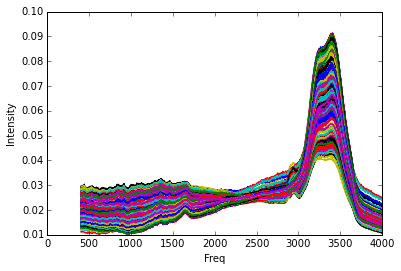

In [8]:
plt.plot(freqs, spectra.T)
plt.xlabel('Freq')
plt.ylabel('Intensity')

#### Distribution of concentrations

There are 21 different values of concentrations.


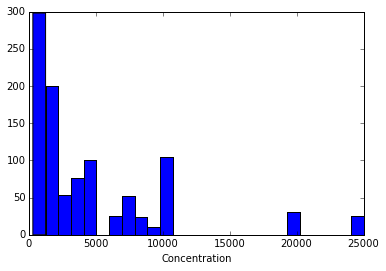

In [9]:
plt.hist(concentration, bins=26)
plt.xlabel('Concentration')
print("There are %s different values of concentrations." % np.unique(concentration).size)

[  300   400   600   800  1000  1400  1600  2000  5000 10000]
[  500  1000  1500  2000  4000  5000  7000 10000 20000 25000]
[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
[  400   800  1000  1200  1600  2000  3000  4000  5000 10000]


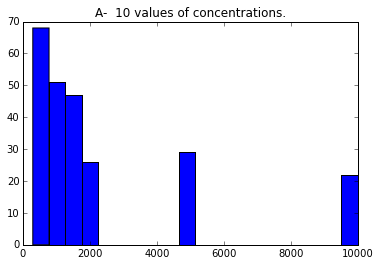

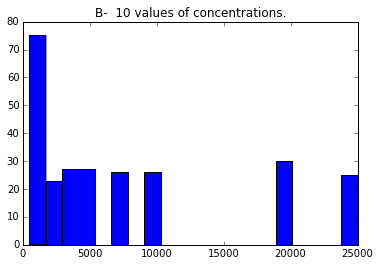

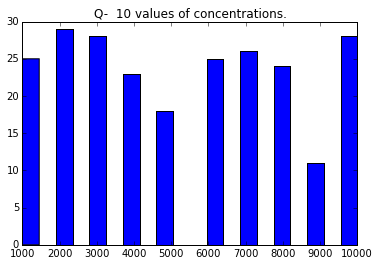

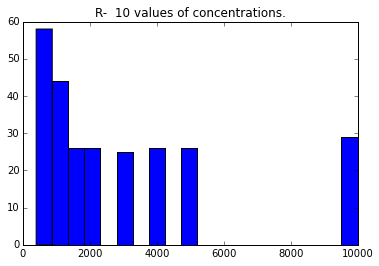

In [10]:
for mol in np.unique(molecule):
    plt.figure()
    plt.hist(concentration[molecule == mol], bins=20)
    plt.title(mol + "-  %s values of concentrations."
              % np.unique(concentration[molecule == mol]).size)
    print(np.unique(concentration[molecule == mol]))

#### Proportion of molecules

Number of samples: 999


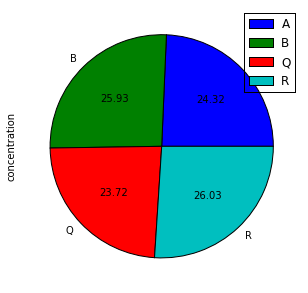

In [11]:
print 'Number of samples: %s' % len(y_df) 
y_df.groupby('molecule').count().plot(y='concentration', kind='pie', autopct='%.2f', figsize=(5, 5));

#### Proportion of solute groups and vial group

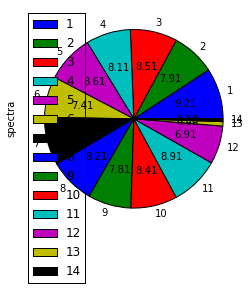

In [12]:
X_df.groupby('solute').count().plot(y='spectra', kind='pie', autopct='%.2f', figsize=(4, 4));

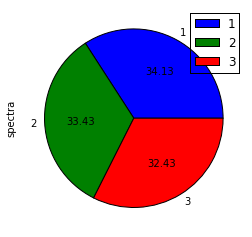

In [13]:
X_df.groupby('vial').count().plot(y='spectra', kind='pie',  autopct='%.2f', figsize=(4, 4))

#### Mean Raman spectra for each concentration value

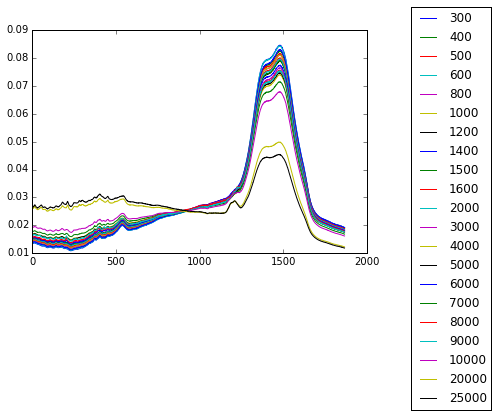

In [14]:
for c in np.unique(concentration):
    plt.plot(np.mean(X[concentration == c, :], axis=0), label="%s" % c)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

#### Raman spectra for each type of molecule

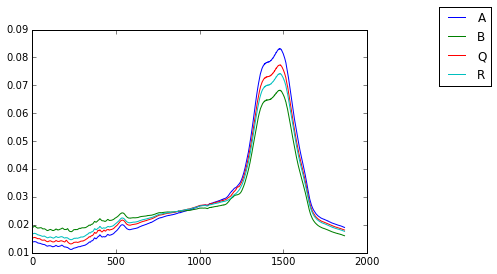

In [15]:
# Mean Raman spectra for each type of molecule
for mol in np.unique(molecule):
    plt.plot(np.mean(X[molecule == mol, :], axis=0), label="%s" % mol)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

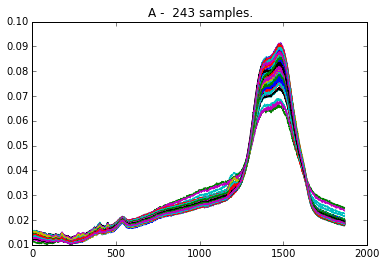

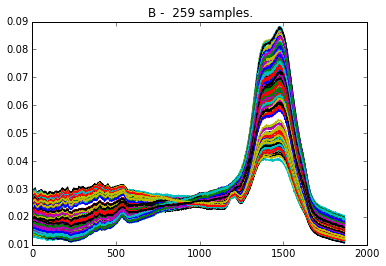

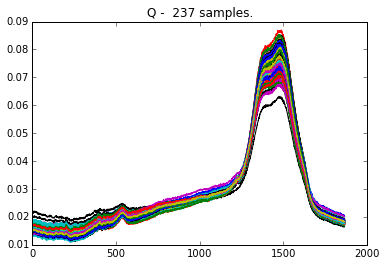

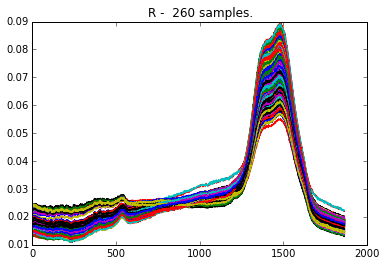

In [16]:
# For each molecule
for mol in np.unique(molecule):
    plt.figure()
    plt.plot(X[molecule == mol, :].T)
    plt.title(mol + " -  %s samples." % X[molecule == mol, :].shape[0]);

## Submission

For your submissions, you have to write 4 classes, saved in 4 different files:   
* the class <code>FeatureExtractorClf</code>, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples, dim of features).  
* a class <code>Classification</code> to predict the molecule type  
* the class <code>FeatureExtractorReg</code>, which will be used to extract features for regression from the dataset and produce a numpy array of size (number of samples, dim of features).  
* a class <code>Regression</code> to predict the molecule concentration  

When submitting these files, they are uploaded to our servers and run to give you a score!  

### Feature extractor for classification

The feature extractor for classification is implemented by the function <code>transform</code> and is saved in the file <code>feature_extractor_clf.py</code>. It receives the pandas dataframe <code>X_df</code> defined at the beginning of the notebook. It should produce a numpy array representing the features extracted, which would be used for the classification.  

Below is an example of a feature extractor. You can copy-paste it into your <code>feature_extractor_clf.py</code> file or write a new one!

In [17]:
import numpy as np
import pandas as pd

class FeatureExtractorClf(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_df):
        pass
    
    def transform(self, X_df):
        XX = np.array([np.array(dd) for dd in X_df['spectra']])
        return XX

### Classification: predicting the molecule type

The classifier follows a classical scikit-learn classifier template. It should be saved in the file <code>classifier.py</code>. In its simplest form it takes a scikit-learn pipeline and assignes it to <code>self.clf</code> in <code>__init__</code>.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

class Classifier(BaseEstimator):
    def __init__(self):
        self.n_components = 100
        self.n_estimators = 300
        self.clf = Pipeline([
            ('pca', PCA(n_components=self.n_components)), 
            ('clf', RandomForestClassifier(n_estimators=self.n_estimators, random_state=42))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Let's put the feature extractor and classifier together and see what we get.  
**You will not have to submit the function <code>train_test_model_clf</code>.** A similar function is implemented on our servers. Your class and associated methods should be called the same way. 

In [19]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

labels = np.array(['A', 'B', 'Q', 'R'])

def train_test_model_clf(X_df, y_df, skf_is, FeatureExtractor, Classifier):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()
    y_train_clf = y_train_df['molecule'].values
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy() 
    y_test_clf = y_test_df['molecule'].values 
    # Feature extraction
    fe_clf = FeatureExtractor()
    fe_clf.fit(X_train_df, y_train_df)
    X_train_array_clf = fe_clf.transform(X_train_df)
    X_test_array_clf = fe_clf.transform(X_test_df)
    # Train
    clf = Classifier()
    clf.fit(X_train_array_clf, y_train_clf)
    # Test 
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = %s' % error)                                                                            
    print('classification report:\n %s' % classification_report(y_test_clf, y_pred_clf))
    print('confusion matrix:\n %s' % confusion_matrix(y_test_clf, y_pred_clf))


skf = ShuffleSplit(len(X_df), n_iter=2, test_size=0.2, random_state=57)  
skf_is = list(skf)[0]

train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

error = 0.11
classification report:
              precision    recall  f1-score   support

          A       0.87      0.87      0.87        63
          B       0.82      0.91      0.86        45
          Q       0.97      0.90      0.94        40
          R       0.92      0.88      0.90        52

avg / total       0.89      0.89      0.89       200

confusion matrix:
 [[55  6  1  1]
 [ 1 41  0  3]
 [ 3  1 36  0]
 [ 4  2  0 46]]


### Feature extractor for regression

Similarly to the feature extractor for classification, the feature extractor for regression should be implemented by a function <code>transform</code> and be part of the <code>FeatureExtractorReg</code> class, saved in the file <code>feature_extractor_reg.py</code>.  
<code>transform</code> receives the pandas dataframe <code>X_df</code> defined at the beginning of the notebook, and optionnally a numpy array. It should produce a numpy array representing the features extracted, which would be used for the regression.

In the example below, the features extracted are the molecule types and the standardized Raman spectra. 
**For the training, it is ok to use the real molecule types, but for testing, we have to use the molecules types predicted during the classification step.** 

In [20]:
labels = np.array(['A', 'B', 'Q', 'R'])

class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y, X_molecule=None):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.median(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)                   
        return XX   

### Regression: predicting the concentration

The regressor follows a classical scikit-learn regressor template. It should be saved in the file <code>regressor.py</code>. In its simplest form it takes a scikit-learn pipeline and assignes it to <code>self.reg</code> in <code>__init__</code>.  

In the example below, one model is created for each type of molecule

As mentionned above, **the error metric is the mean absolute relative error (mare)**: $$\frac{1}{n_{samples}}\sum_{k=1}^{n_{samples}}\left|\frac{y-\hat{y}}{y}\right|$$ with $y$ and $\hat{y}$ being the true and predicted concentration.

In [21]:
from sklearn.ensemble import GradientBoostingRegressor                           
from sklearn.decomposition import PCA                                            
from sklearn.pipeline import Pipeline                                            
from sklearn.base import BaseEstimator                                           
import numpy as np                                                               
                                                                                 
                                                                                 
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 100                                                  
        self.n_estimators = 40                                                   
        self.learning_rate = 0.2                                                 
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}                                                       
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', GradientBoostingRegressor(                               
                    n_estimators=self.n_estimators,                              
                    learning_rate=self.learning_rate,                            
                    random_state=42))                                            
            ])                                                                   
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
        return y_pred                                                                            

Let's put the feature extraction, classification, and regression together, and see what we get!  
Remind that **for the training, it is ok to use the real molecule types, but for testing, we have to use the molecules types predicted during the classification step.**
Note also that you are not forced to consider the molecule types for the regression step.

As mentionned above, **you will not have to submit the function <code>train_test_model</code>**. A similar function is implemented on our servers. Your class and associated methods should be called the same way. 

In [22]:
def mare_score(y_true, y_pred):                                                  
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()                                  
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy()                                    
    y_train_clf = y_train_df['molecule'].values                              
    y_train_reg = y_train_df['concentration'].values                         
    y_test_clf = y_test_df['molecule'].values                                
    y_test_reg = y_test_df['concentration'].values                           

    # Classification
    fe_clf = FeatureExtractorClf()                     
    fe_clf.fit(X_train_df, y_train_df)                                       
    X_train_array_clf = fe_clf.transform(X_train_df)                         
    X_test_array_clf = fe_clf.transform(X_test_df)                           
                                                                                 
    clf = Classifier()                                            
    clf.fit(X_train_array_clf, y_train_clf)                                  
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print 'error = ', error                                                  
    
    # Regression
    fe_reg = FeatureExtractorReg()                     
    for i, label in enumerate(labels):
        # For training, we use 
        X_train_df.loc[:, label] = (y_train_df['molecule'] == label)         
        X_test_df.loc[:, label] = y_proba_clf[:, i]                          
    fe_reg.fit(X_train_df, y_train_reg)                                      
    X_train_array_reg = fe_reg.transform(X_train_df)                         
    X_test_array_reg = fe_reg.transform(X_test_df)                           
                                                                                 
    reg = Regressor()                                              
    reg.fit(X_train_array_reg, y_train_reg)                                  
    y_pred_reg = reg.predict(X_test_array_reg)                               
    mare = mare_score(y_test_reg, y_pred_reg)                                
    print 'mare = ', mare                                                    
    print 'combined error = ', 2. / 3 * error + 1. / 3 * mare


skf = ShuffleSplit(len(X_df), n_iter=2, test_size=0.2, random_state=57) 
skf_is = list(skf)[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.11
mare =  0.225128707754
combined error =  0.148376235918


## Unit testing

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Place the python files <code>classifier.py</code>, <code>feature_extractor.py</code>, <a href = "https://drive.google.com/file/d/0BzwKr6zuOkdRSFJsR19EYVBranM/view?usp=sharing"><code>user_test_model.py</code></a> in a directory, set the paths to the data files in <code>user_test_model.py</code>, and run 

<code>python user_test_model.py</code>


**If it runs and prints**   
<code>
Reading file ...
Training file ...
error =  [some_number_between_0_and_1]
mare =  [some_number_between_0_and_1]
combined error =  [some_number_between_0_and_1]
error =  [some_number_between_0_and_1]
mare =  [some_number_between_0_and_1]
combined error =  [some_number_between_0_and_1]
</code>
**you can submit the code.**